# 导入库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.dates as mdate
import datetime # 用来显示时间的模块
from matplotlib.pyplot import MultipleLocator #从pyplot导入MultipleLocator类，这个类用于设置刻度间隔

#解决中文显示问题
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

#忽略警告
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## 数据读取

In [2]:
# 数据读取
train_data = pd.read_csv('TmallTrainData.csv')
train_target = pd.read_csv('TmallTrainTarget.csv')
test_data = pd.read_csv('TmallTestData.csv') # 竞赛最后提交需要（无label，需要返回prob）

In [3]:
# 删除第一列
train_data.drop(['Unnamed: 0'], axis=1,inplace = True)
train_target.drop(['Unnamed: 0'], axis=1,inplace = True)
test_data.drop(['Unnamed: 0'], axis=1,inplace = True)

## 查看特征

In [4]:
# 查看所有特征
print('有以下这些特征：\n',train_data.columns)
print('\n特征数目：',len(train_data.columns))

有以下这些特征：
 Index(['user_id', 'merchant_id', 'u1用户行为总数', 'u2浏览不同商品数量', 'u3浏览不同商品种类数量',
       'u4访问不同商家的数量', 'u5浏览不同品牌的数量', 'u6最早行为时间', 'u7最晚行为时间', 'u9用户活跃天数',
       'u10点击次数', 'u11加购次数', 'u12购买次数', 'u13收藏次数', 'u14行为类型数', 'm1该商铺被访问次数',
       'm2被不同用户访问的次数', 'm3含不同商品的个数', 'm4含不同商品种类的个数', 'm5含不同品牌的个数', 'm6被点击次数',
       'm7被加购次数', 'm8被购买次数', 'm9被收藏次数', 'm10非新客户数', 'um1该用户对该商铺产生行为次数',
       'um2该用户在该商铺看的不同商品数', 'um3该用户在该商铺看的不同种类数', 'um4该用户在该商铺看的不同品牌数',
       'um5该用户对该商铺的点击数', 'um6该用户对该商铺的加购数', 'um7该用户对该商铺的购买数', 'um8该用户对该商铺的收藏数',
       'um9用户访问该商铺最早时间', 'um10用户访问该商铺最晚时间', 'r1用户购买点击比', 'r2商家购买点击比',
       'r3不同用户不同商家购买点击比', 'age_0.0', 'age_1.0', 'age_2.0', 'age_3.0',
       'age_4.0', 'age_5.0', 'age_6.0', 'age_7.0', 'age_8.0', 'g_0.0', 'g_1.0',
       'g_2.0'],
      dtype='object')

特征数目： 50


# 预测

https://blog.csdn.net/u011630575/article/details/79423162

## 导入库

In [5]:
# 算法辅助&数据
import sklearn
from sklearn.model_selection import KFold, cross_validate # 交叉验证
from sklearn.model_selection import train_test_split

In [6]:
# 算法（单一学习器）
from sklearn.neighbors import KNeighborsClassifier as KNNC # k邻近
from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.tree import DecisionTreeClassifier as DTC # 决策树
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.linear_model import LinearRegression as LR # 线性回归
from sklearn.linear_model import LogisticRegression as LogiR # 逻辑回归
from sklearn.ensemble import RandomForestRegressor as RFR # 随机森林
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingRegressor as GBR # 梯度提升树
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC # 支持向量机分类
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV # 网格搜索
from sklearn.preprocessing import StandardScaler

# 融合模型
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor

# 计数
from collections import Counter
# 时间
import time

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score

## 原始数据

In [7]:
train_data.shape, train_target.shape

((260864, 50), (260864, 1))

In [8]:
X = train_data.values
X

array([[3.41760e+04, 3.90600e+03, 3.31000e+02, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.41760e+04, 1.21000e+02, 3.31000e+02, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.41760e+04, 4.35600e+03, 3.31000e+02, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [2.94527e+05, 1.52000e+02, 1.41000e+02, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [2.94527e+05, 2.53700e+03, 1.41000e+02, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [2.29247e+05, 4.14000e+03, 1.53000e+02, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00]])

In [9]:
y = train_target.label.values
y

array([0., 0., 1., ..., 0., 0., 0.])

In [10]:
print('负样本数量：',sorted(Counter(y).items())[0][1])
print('正样本数量：',sorted(Counter(y).items())[1][1])
print('正样本比例：{:.3%}'.format(int(y.sum())/len(y)))

负样本数量： 244912
正样本数量： 15952
正样本比例：6.115%


## 下采样处理

In [11]:
from imblearn.under_sampling import RandomUnderSampler
RUS = RandomUnderSampler(random_state=0)
train_data_RUS, train_target_RUS = RUS.fit_resample(X, y)
print('原正负样本数量：',sorted(Counter(y).items()))
print('随机下采样后，正负样本数量：',sorted(Counter(train_target_RUS).items()))

原正负样本数量： [(0.0, 244912), (1.0, 15952)]
随机下采样后，正负样本数量： [(0.0, 15952), (1.0, 15952)]


In [12]:
print('下采样前训练数据大小：',train_data.shape, train_target.shape)
print('下采样后训练数据大小：',train_data_RUS.shape,train_target_RUS.shape)

下采样前训练数据大小： (260864, 50) (260864, 1)
下采样后训练数据大小： (31904, 50) (31904,)


In [13]:
print('训练样本减少了{:.2%}'.format((len(train_data)-len(train_data_RUS))/len(train_data)))

训练样本减少了87.77%


In [14]:
# 标准化
stdScaler = StandardScaler()
X_RUS = stdScaler.fit_transform(train_data_RUS)

# 切分数据
X_train_RUS, X_test_RUS, y_train_RUS, y_test_RUS = train_test_split(X_RUS, train_target_RUS, test_size = 0.3)

In [15]:
print('训练数据大小：',X_train_RUS.shape,y_train_RUS.shape)

训练数据大小： (22332, 50) (22332,)


## 定义函数

### 个体学习器

In [16]:
 '''
 对融合模型中每个评估器做交叉验证，对单一评估器的表现进行评估
 '''
def individual_estimators(estimators):
    for estimator in estimators:
        cv = KFold(n_splits = 5, shuffle = True, random_state = 1412)
        
        start = time.time()
        
        results = cross_validate(estimator[1],X_train_RUS, y_train_RUS,
                                 cv = cv,
                                 scoring = 'accuracy',
                                 n_jobs = -1,
                                 return_train_score = True,
                                 verbose = False)
        
        test_score = estimator[1].fit(X_train_RUS, y_train_RUS).score(X_test_RUS, y_test_RUS)
        
        print(estimator[0],
              '\n 消耗时间：{:.3f}s'.format((time.time() - start)),
              '\n train_score:{:.7f}'.format(results['train_score'].mean()),
              '\n cv_mean:{:.7f}'.format(results['test_score'].mean()),
              '\n test_score:{:.7f}'.format(test_score),
              '\n')

### 融合模型

In [17]:
 '''
 对融合模型做交叉验证，对融合模型的表现进行评估
 '''
def fusion_estimators(clf):
    cv = KFold(n_splits = 5, shuffle = True, random_state = 1412)
    
    start = time.time()
    
    results = cross_validate(clf, X_train_RUS, y_train_RUS,
                             cv = cv,
                             scoring = 'accuracy',
                             n_jobs = -1,
                             return_train_score = True,
                             verbose = False)
    
    test_score = clf.fit(X_train_RUS, y_train_RUS).score(X_test_RUS, y_test_RUS)
    
    print('消耗时间：{:.3f}s'.format((time.time() - start)),
          '\n train_score: {:.7f}'.format(results['train_score'].mean()),
          '\n cv_mean: {:.7f}'.format(results['test_score'].mean()),
          '\n test_score: {:.7f}'.format(test_score))

### 调参函数

In [ ]:
from sklearn.model_selection import GridSearchCV

In [18]:
 '''
 调参函数
 '''
def param_GridSearchCV(model, param):
    
    start = time.time()

    gs = GridSearchCV(model, param, cv = 5)
    gs.fit(X_train_RUS, y_train_RUS)

    print('消耗时间：{:.2f}s'.format((time.time() - start)), # 消耗时间
          "\n Best parameters: {}".format(gs.best_params_),
          "\n Best cross-validation score: {:.7f}".format(gs.best_score_))
    # results = pd.DataFrame(LR.cv_results_)

## LR

In [19]:
from sklearn.linear_model import LogisticRegression

### 无调参

In [20]:
model_LR = LogisticRegression()
fusion_estimators(model_LR)

消耗时间：3.191s 
 train_score: 0.5993529 
 cv_mean: 0.5954233 
 test_score: 0.5942332


### 调参

超参数C

In [21]:
LR_model = LogisticRegression()
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}
param_GridSearchCV(LR_model, param_grid)

消耗时间：12.51s 
 Best parameters: {'C': 100} 
 Best cross-validation score: 0.5960503


In [23]:
LR_model = LogisticRegression(max_iter = 3000, C = 100, random_state = 1412, n_jobs = 8)
fusion_estimators(LR_model)

消耗时间：5.969s 
 train_score: 0.5991850 
 cv_mean: 0.5960055 
 test_score: 0.5955913


|逻辑回归|train分数|test分数|
|----|----|----|
|未调参|0.6014688 |0.5910990|
|调参|0.6015472 |0.5912035|

## KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier  # k邻近

### 未调参

In [64]:
model_knn = KNeighborsClassifier(n_neighbors = 10) 
fusion_estimators(model_knn)

消耗时间：112.375s 
 train_score: 0.6508038 
 cv_mean: 0.5505548 
 test_score: 0.5437735


### 调参

参数：n_neighbors

https://blog.csdn.net/sinat_33150417/article/details/83273922

In [82]:
knn_model = KNeighborsClassifier() 
param_grid = [{'n_neighbors':[i for i in range(250, 360, 10)]}]
param_GridSearchCV(knn_model, param_grid)

消耗时间：121.40s 
 Best parameters: {'n_neighbors': 320} 
 Best cross-validation score: 0.5748700


In [83]:
knn_model = KNeighborsClassifier(n_neighbors = 320)
fusion_estimators(knn_model)

消耗时间：140.414s 
 train_score: 0.5802884 
 cv_mean: 0.5743328 
 test_score: 0.5675930


|k邻近|train分数|test分数|
|----|----|----|
|未调参|nan |0.5382365|
|调参|0.5802884 |0.5675930|

## SVM

https://blog.csdn.net/weixin_42480762/article/details/122057455

In [53]:
from sklearn.svm import SVC # 支持向量机分类

### 未调参

In [54]:
model_svc = SVC(probability = True) # probability = True 
fusion_estimators(model_svc)

消耗时间：1139.567s 
 train_score: 0.6413442 
 cv_mean: 0.5953784 
 test_score: 0.5926661


In [55]:
model_svc = SVC(kernel = 'linear', probability = True) # probability = True 
fusion_estimators(model_svc)

消耗时间：1665.320s 
 train_score: 0.5863671 
 cv_mean: 0.5823479 
 test_score: 0.5821145


### 调参

选用rbf支持向量机：含有参数C和gamma

In [ ]:
svc_model = SVC(probability = True) # probability = True 
param_grid = [{'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}]
param_GridSearchCV(svc_model, param_grid)

In [ ]:
svc_model = SVC(probability = True)
fusion_estimators(svc_model)

## DT

In [27]:
from sklearn.tree import DecisionTreeClassifier

### 未调参

In [28]:
model_tree = DecisionTreeClassifier()
fusion_estimators(model_tree)

消耗时间：2.145s 
 train_score: 1.0000000 
 cv_mean: 0.5407929 
 test_score: 0.5434601


### 调参

max_features、min_samples_leaf、max_depth

In [29]:
DT_model = DecisionTreeClassifier()
param_grid = {'max_features': ["auto","sqrt","log2"],
              'min_samples_leaf': range(1,100,10), 
              'max_depth': range(1,50,10)}
param_GridSearchCV(DT_model, param_grid)

消耗时间：40.06s 
 Best parameters: {'max_depth': 21, 'max_features': 'auto', 'min_samples_leaf': 91} 
 Best cross-validation score: 0.5817202


In [30]:
DT_model = DecisionTreeClassifier(max_depth = 21, max_features = 'auto', min_samples_leaf = 91)
fusion_estimators(DT_model)

消耗时间：0.386s 
 train_score: 0.6245074 
 cv_mean: 0.5802438 
 test_score: 0.5734434


|决策树|train分数|test分数|
|----|----|----|
|未调参|1.0|0.5448182|
|调参|0.6225820 |0.5950690|

## GBC

In [55]:
from sklearn.ensemble import GradientBoostingClassifier

### 未调参

In [56]:
model_GBC = GradientBoostingClassifier() # 无n_jobs参数
fusion_estimators(model_GBC)

消耗时间：33.898s 
 train_score: 0.6450497 
 cv_mean: 0.6128426 
 test_score: 0.6091726


### 调参

参数：n_estimators、max_features

In [ ]:
GBC_model = GradientBoostingClassifier()
param_grid = 
param_GridSearchCV(GBC_model, param_grid)

In [ ]:
GBC_model = GradientBoostingClassifier(n_estimators = 100, max_features = 16, random_state = 1412) # 无n_jobs参数
fusion_estimators(model_GBC)

|梯度提升树|train分数|test分数|
|----|----|----|
|未调参|0.6450497 |0.6091726|
|调参|||

## RF

In [33]:
from sklearn.ensemble import RandomForestClassifier

### 未调参

In [34]:
model_RF = RandomForestClassifier()
fusion_estimators(model_RF)

消耗时间：22.277s 
 train_score: 1.0000000 
 cv_mean: 0.6012444 
 test_score: 0.6076055


### 调参

随机森林主要的参数有n_estimators（子树的数量）、max_depth（树的最大生长深度）、min_samples_leaf（叶子的最小样本数量）、min_samples_split(分支节点的最小样本数量）、max_features（最大选择特征数）。

https://zhuanlan.zhihu.com/p/126288078

https://www.cnblogs.com/pinard/p/6160412.html

https://blog.csdn.net/u012768474/article/details/92829985

#### n_estimators

In [21]:
# 建立随机森林
rfc = RandomForestClassifier(n_estimators = 100, random_state = 90)

# 用交叉验证计算得分
score_pre = cross_val_score(rfc, X_train_RUS, y_train_RUS, cv = 5).mean()
score_pre

0.6046031047605813

消耗时间：497.106s
最大得分：0.6096631605 子树数量为：191


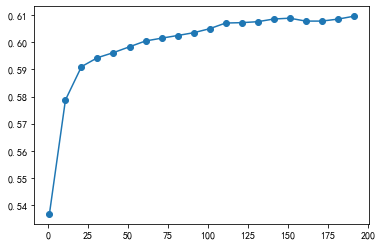

In [28]:
from sklearn.ensemble import RandomForestClassifier
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []

start = time.time()

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators = i+1, random_state=90)
    score = cross_val_score(rfc, X_train_RUS, y_train_RUS, cv = 5).mean()
    score_lt.append(score)
score_max = max(score_lt)

print('消耗时间：{:.3f}s'.format((time.time() - start)))# 消耗时间

print('最大得分：{:.10f}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# 绘制学习曲线
x = np.arange(1,201,10)
plt.subplot(111)
plt.plot(x, score_lt, 'o-')
plt.show()

消耗时间：955.794s
最大得分：0.6097976593240715 子树数量为：193


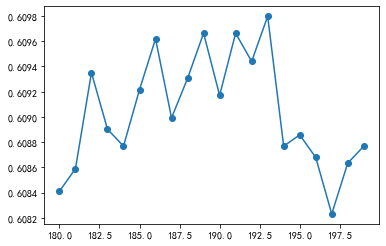

In [29]:
# 在191附近缩小n_estimators的范围181-200
score_lt = []

start = time.time()

for i in range(180,200):
    rfc = RandomForestClassifier(n_estimators = i, random_state = 90)
    score = cross_val_score(rfc, X_train_RUS, y_train_RUS, cv = 5).mean()
    score_lt.append(score)
score_max = max(score_lt)

print('消耗时间：{:.3f}s'.format((time.time() - start)))# 消耗时间

print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)+180))

# 绘制学习曲线
x = np.arange(180,200)
plt.subplot(111)
plt.plot(x, score_lt,'o-')
plt.show()

#### max_depth

使模型复杂度减小

In [30]:
# 建立n_estimators为193的随机森林
rfc = RandomForestClassifier(n_estimators = 193, random_state = 90)

start = time.time()

# 用网格搜索调整max_depth
param_grid = {'max_depth':np.arange(1,20)}
GS = GridSearchCV(rfc, param_grid, cv = 5)
GS.fit(X_train_RUS, y_train_RUS)

print('消耗时间：{:.2f}s'.format((time.time() - start)))# 消耗时间
print('最优参数：',GS.best_params_)
print('最优得分：',GS.best_score_)

消耗时间：535.83s
最优参数： {'max_depth': 14}
最优得分： 0.614186394108119


#### max_features

使得模型复杂度增大

In [31]:
X_train_RUS.shape

(22332, 50)

查看数据集大小，发现一共有50列特征，由于max_features默认取值特征数量的开平方值，因此我们从7开始调整

In [35]:
start = time.time()

# 用网格搜索调整max_features
param_grid = {'max_features':np.arange(7,31)}

rfc = RandomForestClassifier(n_estimators = 193, 
                             random_state = 90, 
                             max_depth = 14)

GS = GridSearchCV(rfc, param_grid, cv = 5)
GS.fit(X_train_RUS, y_train_RUS)

print('消耗时间：{:.2f}s'.format((time.time() - start)))# 消耗时间
print('最优参数：',GS.best_params_)
print('最优得分：',GS.best_score_)

消耗时间：2405.99s
最优参数： {'max_features': 20}
最优得分： 0.6161114932403231


In [38]:
RF_model = RandomForestClassifier(n_estimators = 193, max_depth = 14, max_features = 20, random_state = 90, n_jobs = 8)
fusion_estimators(RF_model)

消耗时间：39.726s 
 train_score: 0.9319698 
 cv_mean: 0.6067969 
 test_score: 0.6207689


In [36]:
'''
from sklearn.ensemble import RandomForestClassifier
 
rfc = RandomForestClassifier(n_estimators = 193, 
                             random_state = 90, 
                             max_depth = 14)

param_grid = {'max_features':['auto','sqrt','log2']}
 
from sklearn.model_selection import GridSearchCV

start = time.time()

GS = GridSearchCV(rfc, param_grid, cv = 5)
GS.fit(X_train_RUS, y_train_RUS)

print('消耗时间：{:.2f}s'.format((time.time() - start)))# 消耗时间
print('最优参数：',GS.best_params_)
print('最优得分：',GS.best_score_)
'''

消耗时间：137.87s
最优参数： {'max_features': 'auto'}
最优得分： 0.614186394108119


## XGBoost

In [31]:
from xgboost import XGBClassifier

### 未调参

In [32]:
model_XGB = XGBClassifier()
fusion_estimators(model_XGB)

[11:32:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
消耗时间：20.322s 
 train_score: 0.8619134 
 cv_mean: 0.6004386 
 test_score: 0.6120978


### 调参

## 模型融合

### 投票法

#### 未调参

In [39]:
clf1 = LogisticRegression(max_iter = 3000, random_state = 90, n_jobs = 8)
clf2 = DecisionTreeClassifier(max_depth = 8, random_state = 90)
clf3 = RFC(n_estimators = 100, random_state = 1412, n_jobs = 8)
clf4 = XGBClassifier() 

estimators = [('Logistic Regression',clf1), 
              ('DecisionTree',clf2), 
              ('RandomForest',clf3),
              ('XGBoost',clf4)]

clf = VotingClassifier(estimators,voting = 'soft')

In [40]:
individual_estimators(estimators)

Logistic Regression 
 消耗时间：5.655s 
 train_score:0.5989947 
 cv_mean:0.5951547 
 test_score:0.5936064 

DecisionTree 
 消耗时间：1.166s 
 train_score:0.6426652 
 cv_mean:0.5851693 
 test_score:0.5857710 

RandomForest 
 消耗时间：11.402s 
 train_score:1.0000000 
 cv_mean:0.6008411 
 test_score:0.6108441 

[11:48:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost 
 消耗时间：18.951s 
 train_score:0.8619134 
 cv_mean:0.6004386 
 test_score:0.6120978 



In [41]:
fusion_estimators(clf) 

[11:49:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
消耗时间：50.830s 
 train_score: 0.9349364 
 cv_mean: 0.6092599 
 test_score: 0.6143962


||LR(对照)|融合模型|
|----|----|----|
|5折交叉验证|0.5951547|0.6092599|
|测试集分数|0.5936064|0.6143962|

增加多样性

In [84]:
clf1 = LogisticRegression(max_iter = 3000, random_state = 90, n_jobs = 8)
clf2 = DecisionTreeClassifier(max_depth = 8, random_state = 90)
clf3 = RFC(n_estimators = 100, random_state = 1412, n_jobs = 8)
clf4 = XGBClassifier() 
clf5 = KNeighborsClassifier(n_neighbors = 20, n_jobs = 8)

estimators = [('Logistic Regression',clf1), 
              ('DecisionTree',clf2), 
              ('RandomForest',clf3),
              ('XGBoost',clf4),
              ('KNN',clf5)]

clf = VotingClassifier(estimators,voting = 'soft')

In [ ]:
individual_estimators(estimators)

In [85]:
fusion_estimators(clf) 

[14:53:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
消耗时间：116.248s 
 train_score: nan 
 cv_mean: 0.6109167 
 test_score: 0.6150230


||LR(对照)|融合模型| 增加多样性|
|----|----|----|----|
|5折交叉验证|0.5951547|0.6092599|0.6109167|
|测试集分数|0.5936064|0.6143962|0.6150230|

#### 细微调参

In [89]:
clf1 = LogisticRegression(max_iter = 3000, C = 100, random_state = 90, n_jobs = 8)
clf2 = DecisionTreeClassifier(max_depth = 21, max_features = 'auto', min_samples_leaf = 91, random_state = 90)
clf3 = RandomForestClassifier(n_estimators = 193, max_depth = 14, max_features = 20, random_state = 90, n_jobs = 8)
clf4 = XGBClassifier() 
clf5 = KNeighborsClassifier(n_neighbors = 320, n_jobs = 8)

estimators = [('Logistic Regression',clf1), 
              ('DecisionTree',clf2), 
              ('RandomForest',clf3),
              ('XGBoost',clf4),
              ('KNN',clf5)]

clf = VotingClassifier(estimators,voting = 'soft')

In [90]:
individual_estimators(estimators)

Logistic Regression 
 消耗时间：8.292s 
 train_score:0.5991850 
 cv_mean:0.5960055 
 test_score:0.5955913 

DecisionTree 
 消耗时间：1.196s 
 train_score:0.6206341 
 cv_mean:0.5716009 
 test_score:0.5821145 

RandomForest 
 消耗时间：37.224s 
 train_score:0.9319698 
 cv_mean:0.6067969 
 test_score:0.6207689 

[15:09:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost 
 消耗时间：22.677s 
 train_score:0.8619134 
 cv_mean:0.6004386 
 test_score:0.6120978 

KNN 
 消耗时间：136.743s 
 train_score:nan 
 cv_mean:0.5743328 
 test_score:0.5675930 



In [91]:
fusion_estimators(clf) 

[15:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
消耗时间：127.662s 
 train_score: nan 
 cv_mean: 0.6099315 
 test_score: 0.6178437


||LR(对照)|融合模型| 增加多样性| 细微调参
|----|----|----|----|----|
|5折交叉验证|0.5951547|0.6092599(+)|0.6109167(+)|0.6099315(-)|
|测试集分数|0.5936064|0.6143962(+)|0.6150230(+)|0.6178437(+)|

交叉验证分数下降了0.001，但是测试集分数继续上升了0.002

#### 调整融合模型（赋权）

① 使用各个学习器交叉验证分数作为权重，但有一定过拟合风险

In [93]:
estimators = [('Logistic Regression',clf1), 
              ('DecisionTree',clf2), 
              ('RandomForest',clf3),
              ('XGBoost',clf4),
              ('KNN',clf5)]

clf_weighted = VotingClassifier(estimators, voting = 'soft', weights = [0.5960055,0.5716009,0.6067969,0.6004386,0.5743328])

In [94]:
fusion_estimators(clf_weighted) 

[15:27:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
消耗时间：190.086s 
 train_score: nan 
 cv_mean: 0.6104689 
 test_score: 0.6178437


||LR(对照)|融合模型| 增加多样性| 细微调参|赋权|
|----|----|----|----|----|----|
|5折交叉验证|0.5951547|0.6092599(+)|0.6109167(+)|0.6099315(-)|0.6104689(+)|
|测试集分数|0.5936064|0.6143962(+)|0.6150230(+)|0.6178437(+)|0.6178437(无变化)|

赋权后交叉验证分数提升。测试集分数未变化，无过拟合产生。尝试粗糙赋权：

② 略微降低权重精度，也许可以一定程度抵消过拟合

In [97]:
clf_weighted2 = VotingClassifier(estimators, voting = 'soft', weights = [0.60,0.57,0.61,0.60,0.57])

In [98]:
fusion_estimators(clf_weighted2) 

[15:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
消耗时间：148.227s 
 train_score: nan 
 cv_mean: 0.6106480 
 test_score: 0.6177392


||LR(对照)|融合模型| 增加多样性| 细微调参|赋权|下调赋权精度|
|----|----|----|----|----|----|----|
|5折交叉验证|0.5951547|0.6092599(+)|0.6109167(+)|0.6099315(-)|0.6104689(+)|0.6106480(+)|
|测试集分数|0.5936064|0.6143962(+)|0.6150230(+)|0.6178437(+)|0.6178437(无变化)|0.6177392(-)|

测试集分数略微降低了0.001，轻微过拟合

③ 加大效果好的算法权重，降低差的

In [99]:
# 加大效果好的算法权重
clf_weighted3 = VotingClassifier(estimators, voting = 'soft', weights = [0.70,0.57,0.85,0.70,0.57])

In [100]:
fusion_estimators(clf_weighted3) 

[15:46:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
消耗时间：124.157s 
 train_score: nan 
 cv_mean: 0.6115436 
 test_score: 0.6187840


||LR(对照)|融合模型| 增加多样性| 细微调参|赋权|下调赋权精度|加大效果好的算法权重|
|----|----|----|----|----|----|----|----|
|5折交叉验证|0.5951547|0.6092599(+)|0.6109167(+)|0.6099315(-)|0.6104689(+)|0.6106480(+)|0.6115436(+)|
|测试集分数|0.5936064|0.6143962(+)|0.6150230(+)|0.6178437(+)|0.6178437(无变化)|0.6177392(-)|0.6187840(+)|

加大效果好的算法权重后，交叉验证分数与测试集分数都达到新高

In [106]:
# 降低差的算法的权重
clf_weighted4 = VotingClassifier(estimators, voting = 'soft', weights = [0.70,0.4,0.85,0.70,0.4])

In [107]:
fusion_estimators(clf_weighted4) 

[16:05:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
消耗时间：130.669s 
 train_score: nan 
 cv_mean: 0.6122153 
 test_score: 0.6212913


降低差的算法的权重后，交叉验证分数与测试集分数都达到新高

||LR(对照)|融合模型| 增加多样性| 细微调参|赋权|下调赋权精度|加好的算法权重|降低差的算法的权重|
|----|----|----|----|----|----|----|----|----|
|5折交叉验证|0.5951547|0.6092599(+)|0.6109167(+)|0.6099315(-)|0.6104689(+)|0.6106480(+)|0.6115436(+)|0.6122153(+)|
|测试集分数|0.5936064|0.6143962(+)|0.6150230(+)|0.6178437(+)|0.6178437(无变化)|0.6177392(-)|0.6187840(+)|0.6212913(+)|

### 堆叠法

In [109]:
# stacking 模型融合
from sklearn.ensemble import StackingClassifier

In [110]:
clf1 = LogisticRegression(max_iter = 3000, C = 100, random_state = 90, n_jobs = 8)
clf2 = DecisionTreeClassifier(max_depth = 21, max_features = 'auto', min_samples_leaf = 91, random_state = 90)
clf3 = XGBClassifier() 
clf4 = KNeighborsClassifier(n_neighbors = 320, n_jobs = 8)

In [111]:
# 个体学习器
estimators = [('Logistic Regression',clf1), 
              ('DecisionTree',clf2), 
              ('XGBoost',clf3),
              ('KNN',clf4)]

In [118]:
# 元学习器(分类的元学习器需要复杂一点)
final_estimator = RFC(n_estimators = 193, 
                      max_depth = 14, 
                      # max_features = 20,
                      # min_impurity_decrease = 0.0025,# 微小抗过拟合
                      random_state = 90, 
                      n_jobs = 8)
# stacking实例化
Stacking_clf = StackingClassifier(estimators = estimators, 
                                  final_estimator = final_estimator, 
                                  stack_method = 'auto',
                                  n_jobs = 8)

In [119]:
fusion_estimators(Stacking_clf) 

消耗时间：198.511s 
 train_score: nan 
 cv_mean: 0.6002142 
 test_score: 0.6055161


In [127]:
# 元学习器(分类的元学习器需要复杂一点)
final_estimator = RFC(n_estimators = 193, 
                      max_depth = 14, 
                      # max_features = 20,
                      min_impurity_decrease = 0.0025,# 微小抗过拟合
                      random_state = 90, 
                      n_jobs = 8)
# stacking实例化
Stacking_clf2 = StackingClassifier(estimators = estimators, 
                                  final_estimator = final_estimator, 

                                  n_jobs = 8)

In [128]:
fusion_estimators(Stacking_clf2)

MemoryError: Unable to allocate 609. MiB for an array with shape (4467, 17865) and data type float64